In [14]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sb

print(plt.style.available)
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = 8, 4

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn', u'seaborn-poster', u'seaborn-bright', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [2]:
from pymongo import MongoClient

def get_mongo_database(db_name, host='localhost', port=27017, username=None, password=None):
    '''Get (or create) named database from MongoDB with/out authentication'''
    if username and password:
        mongo_uri = 'mongodb://{}:{}@{}/{}'.format(username, password, host, db_name)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db_name]

def mongo_to_dataframe(db_name, collection_name, query={}, host='localhost',
                       port=27017, username=None, password=None, no_id=True):
    '''Create a Pandas DataFrame from MongoDB collection'''
    db = get_mongo_database(db_name, host, port, username, password)
    cursor = db[collection_name].find(query)
    df = pd.DataFrame(list(cursor))
    if no_id:
        del df['_id']
    return df

def dataframe_to_mongo(dframe, db_name, collection_name, host='localhost',
                 port=27017, username=None, password=None):
    '''save a dataframe to mongodb collection'''
    db = get_mongo_database(db_name, host, port, username, password)
    records = df.to_dict('records')  # 'records' puts it into our list-of-dicts format
    db[collection_name].insert_many(records)




In [5]:
#----------------------------
# From json file.
#----------------------------
if False:
    with open('data/nwinners.json') as f:
        df = pd.read_json(f)

# Saving data
# Make sure mongodb is clear (so we don't duplicate data), then
# save to Mongo for next section
if False:
    db = get_mongo_database(DB_NOBEL_PRIZE)
    db[COLL_WINNERS].delete_many({})  # deletes everything (no filter)
    dataframe_to_mongo(df, DB_NOBEL_PRIZE, COLL_WINNERS) # save to Mongo for next section

#----------------------------
# From mongodb collection
#----------------------------
DB_NOBEL_PRIZE = 'nobel_prize' # use string constants or a spell error in retrieval will create new table.
COLL_WINNERS = 'winners_all' # winners collection

df = mongo_to_dataframe(DB_NOBEL_PRIZE, COLL_WINNERS)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 12 columns):
born_in           2138 non-null object
category          2138 non-null object
country           2138 non-null object
date_of_birth     2120 non-null object
date_of_death     1424 non-null object
gender            2120 non-null object
link              2138 non-null object
name              2138 non-null object
place_of_birth    2120 non-null object
place_of_death    1424 non-null object
text              2138 non-null object
year              2138 non-null int64
dtypes: int64(1), object(11)
memory usage: 200.5+ KB


In [7]:
# convert the date columns to a usable form
df.date_of_birth = pd.to_datetime(df.date_of_birth)
df.date_of_death = pd.to_datetime(df.date_of_death)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 12 columns):
born_in           2138 non-null object
category          2138 non-null object
country           2138 non-null object
date_of_birth     2120 non-null datetime64[ns]
date_of_death     1424 non-null datetime64[ns]
gender            2120 non-null object
link              2138 non-null object
name              2138 non-null object
place_of_birth    2120 non-null object
place_of_death    1424 non-null object
text              2138 non-null object
year              2138 non-null int64
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 200.5+ KB


In [9]:
by_gender = df.groupby('gender')
print(by_gender.size())

gender
female     114
male      2006
dtype: int64


In [10]:
by_gender.size().plot(kind='bar')

In [11]:
by_cat_gen = df.groupby(['category', 'gender'])
by_cat_gen.get_group(('Physics', 'female'))[['name', 'year']] #get a group by a category and gender key

name  year
100   Maria Goeppert-Mayer *  1963
112              Marie Curie  1903
410     Maria Goeppert-Mayer  1963
924   Marie Skłodowska-Curie  1903
1169  Maria Goeppert-Mayer *  1963
1181             Marie Curie  1903
1479    Maria Goeppert-Mayer  1963
1993  Marie Skłodowska-Curie  1903

In [12]:
by_cat_gen.size()

category                gender
                        male       14
Chemistry               female     10
                        male      424
Economics               female      2
                        male      184
Literature              female     32
                        male      228
Peace                   female     32
                        male      200
Physics                 female      8
                        male      474
Physiology or Medicine  female     30
                        male      482
dtype: int64

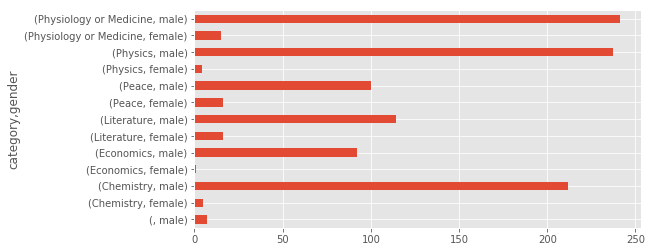

In [25]:
by_cat_gen.size().plot(kind='barh')

gender      female   male
category                 
               NaN    7.0
Chemistry      5.0  212.0
Economics      1.0   92.0
Literature    16.0  114.0
Peace         16.0  100.0


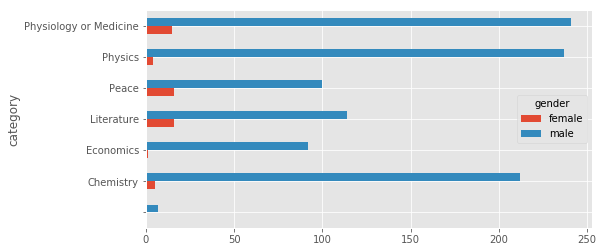

In [26]:
print(by_cat_gen.size().unstack().head())
by_cat_gen.size().unstack().plot(kind='barh')

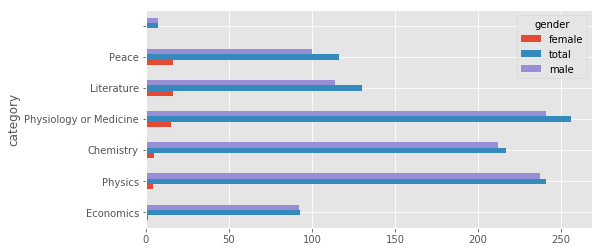

In [27]:
cat_gen_sz = by_cat_gen.size().unstack()
cat_gen_sz['total'] = cat_gen_sz.sum(axis=1)
cat_gen_sz = cat_gen_sz.sort_values(by='female', ascending=True)
cat_gen_sz[['female', 'total', 'male']].plot(kind='barh')

In [28]:
df[(df.category == 'Physics') & (df.gender == 'female')]\
[['name', 'country','year']]

name        country  year
136  Marie Skłodowska-Curie         Poland  1903
381  Maria Goeppert-Mayer *                 1963
393             Marie Curie         France  1903
691    Maria Goeppert-Mayer  United States  1963

In [29]:
by_year_gender = df.groupby(['year','gender'])
year_gen_sz = by_year_gender.size().unstack()
year_gen_sz.plot(kind='bar', figsize=(16,4))

In [18]:
def thin_xticks(ax, tick_gap=10, rotation=45):
    """ Thin x-ticks and adjust rotation """
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::tick_gap])
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap], rotation=rotation)
    ax.figure.show()

In [61]:
by_year_gender = df.groupby(['year', 'gender'])
by_year_gender.size().unstack()

gender  female  male
year                
1901       NaN     6
1902       NaN     7
1903         1     6
1904       NaN     5
1905         1     4
1906       NaN     6
1907       NaN     6
1908       NaN     7
1909         1     6
1910       NaN     4
1911         1     5
1912       NaN     6
1913       NaN     5
1914       NaN     3
1915       NaN     4
1916       NaN     1
1917       NaN     3
1918       NaN     2
1919       NaN     4
1920       NaN     5
1921       NaN     5
1922       NaN     5
1923       NaN     4
1924       NaN     3
1925       NaN     5
1926         1     5
1927       NaN     7
1928         1     3
1929       NaN     7
1930       NaN     5
...        ...   ...
1985       NaN     7
1986         1    11
1987       NaN     9
1988         1    10
1989       NaN    10
1990       NaN    11
1991         2     5
1992         1     6
1993         1    10
1994       NaN    13
1995         1     9
1996         1    12
1997         1    10
1998       NaN    11
1999       Na

In [60]:
new_index = pd.Index(np.arange(1901, 2015), name='year')
by_year_gender = df.groupby(['year','gender'])
year_gen_sz = by_year_gender.size().unstack().reindex(new_index)
fig, axes = plt.subplots(nrows=2, ncols=1,
sharex=True, sharey=True)
ax_f = axes[0]
ax_m = axes[1]
fig.suptitle('Nobel Prize-winners by gender', fontsize=16)
ax_f.bar(year_gen_sz.index, year_gen_sz.female)
ax_f.set_ylabel('Female winners')
ax_m.bar(year_gen_sz.index, year_gen_sz.male)
ax_m.set_ylabel('Male winners')
ax_m.set_xlabel('Year')

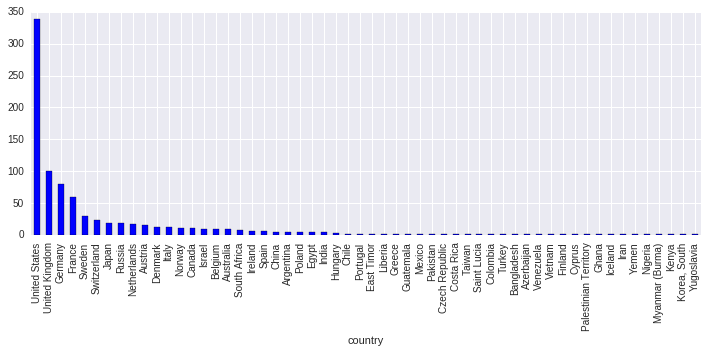

In [20]:
df.groupby('country').size().sort_values(ascending=False)\
.plot(kind='bar', figsize=(12,4))

In [62]:
nat_group = df.groupby('country')
ngsz = nat_group.size()
ngsz.index

Index([u'Argentina', u'Australia', u'Austria', u'Azerbaijan', u'Bangladesh',
       u'Belgium', u'Canada', u'Chile', u'China', u'Colombia', u'Costa Rica',
       u'Cyprus', u'Czech Republic', u'Denmark', u'East Timor', u'Egypt',
       u'Finland', u'France', u'Germany', u'Ghana', u'Greece', u'Guatemala',
       u'Hungary', u'Iceland', u'India', u'Iran', u'Ireland', u'Israel',
       u'Italy', u'Japan', u'Kenya', u'Korea, South', u'Liberia', u'Mexico',
       u'Myanmar (Burma)', u'Netherlands', u'Nigeria', u'Norway', u'Pakistan',
       u'Palestinian Territory', u'Poland', u'Portugal', u'Russia',
       u'Saint Lucia', u'South Africa', u'Spain', u'Sweden', u'Switzerland',
       u'Taiwan', u'Turkey', u'United Kingdom', u'United States', u'Vietnam',
       u'Yemen', u'Yugoslavia'],
      dtype='object', name=u'country')

In [63]:
df_countries = pd.read_json('data/winning_country_data.json', orient='index')

In [64]:
df_countries.ix[0]

alpha3Code               ARG
area              2.7804e+06
capital         Buenos Aires
gini                    44.5
latlng        [-34.0, -64.0]
name               Argentina
population          42669500
Name: Argentina, dtype: object

In [65]:
df_countries = df_countries.set_index('name')
df_countries['nobel_wins'] = ngsz
df_countries['nobel_wins_per_capita'] =\
df_countries.nobel_wins / df_countries.population

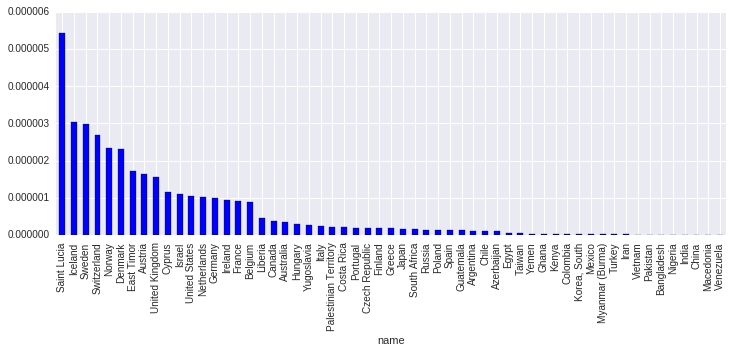

In [66]:
df_countries.sort_values(by='nobel_wins_per_capita', ascending=False)\
.nobel_wins_per_capita.plot(kind='bar', figsize=(12,4))

In [67]:
# filter for countries with more than two Nobel prizes
df_countries[df_countries.nobel_wins > 2]\
.sort_values(by='nobel_wins_per_capita', ascending=False)\
.nobel_wins_per_capita.plot(kind='bar')

In [27]:
nat_cat_sz = df.groupby(['country', 'category']).size().unstack()
nat_cat_sz[:5] # take the first five countries by category

category    Chemistry  Economics  Literature  Peace  Physics  \
country                                                        
Argentina           1        NaN         NaN      2      NaN   
Australia         NaN          1           1    NaN        1   
Austria             3          1           1      2        4   
Azerbaijan        NaN        NaN         NaN    NaN        1   
Bangladesh        NaN        NaN         NaN      1      NaN   

category    Physiology or Medicine  
country                             
Argentina                        2  
Australia                        6  
Austria                          4  
Azerbaijan                     NaN  
Bangladesh                     NaN  

In [68]:
COL_NUM = 2
ROW_NUM = 3
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))
for i, (label, col) in enumerate(nat_cat_sz.iteritems()):
    ax = axes[i/COL_NUM, i%COL_NUM]
    col = col.sort_values(ascending=False)[:10]
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)
plt.tight_layout()

In [29]:
# increase the font size 
plt.rcParams['font.size'] = 20

In [30]:
new_index = pd.Index(np.arange(1901, 2015), name='year')
by_year_nat_sz = df.groupby(['year', 'country'])\
.size().unstack().reindex(new_index)

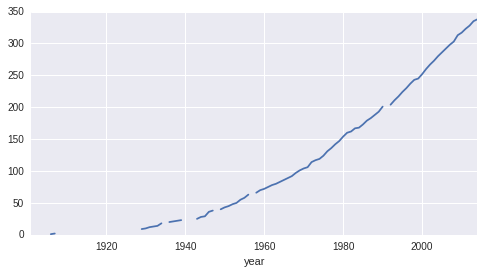

In [31]:
by_year_nat_sz['United States'].cumsum().plot()

In [32]:
by_year_nat_sz['United States'].fillna(0).cumsum().plot()

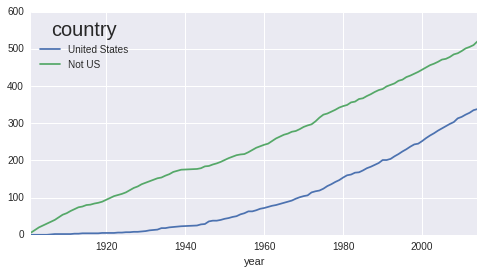

In [33]:
by_year_nat_sz = df.groupby(['year', 'country']).size().unstack().fillna(0)
not_US = by_year_nat_sz.columns.tolist()
not_US.remove('United States')
by_year_nat_sz['Not US'] = by_year_nat_sz[not_US].sum(axis=1)
ax = by_year_nat_sz[['United States', 'Not US']].cumsum().plot()

In [34]:
by_year_nat_sz = df.groupby(['year', 'country'])\
.size().unstack().reindex(new_index).fillna(0)

regions = [
{'label':'N. America',
'countries':['United States', 'Canada']},
{'label':'Europe',
'countries':['United Kingdom', 'Germany', 'France']},
{'label':'Asia',
'countries':['Japan', 'Russia', 'India']}
]

for region in regions:
    by_year_nat_sz[region['label']] =\
    by_year_nat_sz[region['countries']].sum(axis=1)
    
by_year_nat_sz[[r['label'] for r in regions]].cumsum().plot()

In [72]:
COL_NUM = 4 
ROW_NUM = 4

by_nat_sz = df.groupby('country').size()
by_nat_sz.sort_values(ascending=False, inplace=True)
fig, axes = plt.subplots(COL_NUM, ROW_NUM,\
sharex=True, sharey=True,
figsize=(12,12))
for i, nat in enumerate(by_nat_sz.index[1:17]):
    ax = axes[i/COL_NUM, i%ROW_NUM]
    by_year_nat_sz[nat].cumsum().plot(ax=ax)
    ax.set_title(nat)

In [73]:
import seaborn as sns

In [74]:
bins = np.arange(df.year.min(), df.year.max(), 10)
by_year_nat_binned = df.groupby(
['country', pd.cut(df.year, bins, precision=0)]).size().unstack().fillna(0)
plt.figure(figsize=(8,8))
sns.heatmap(by_year_nat_binned[by_year_nat_binned.sum(axis=1) > 2])

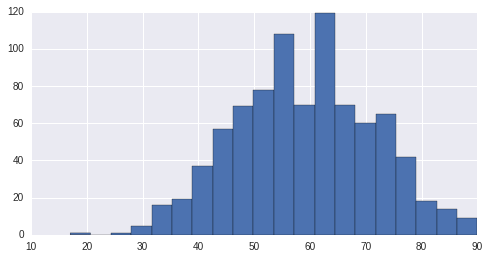

In [84]:
df['award_age'].hist(bins=20)

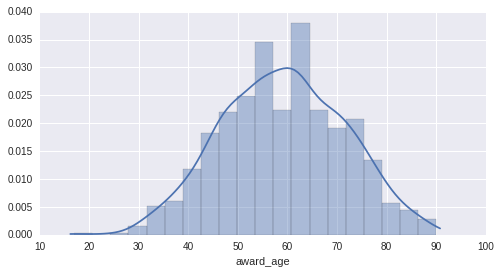

In [86]:
sns.distplot(df['award_age'])

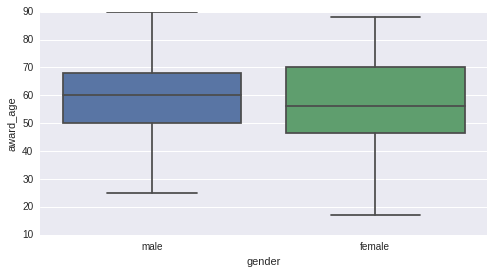

In [87]:
sns.boxplot(df.gender, df.award_age)

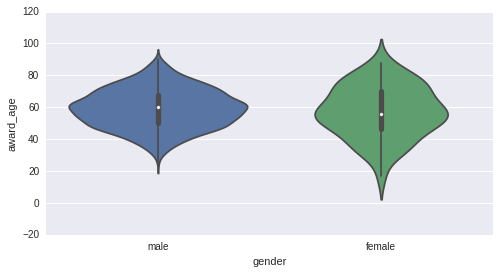

In [88]:
sns.violinplot(df.gender, df.award_age)

In [92]:
df['age_at_death'] = (df.date_of_death - df.date_of_birth)\
.dt.days/365

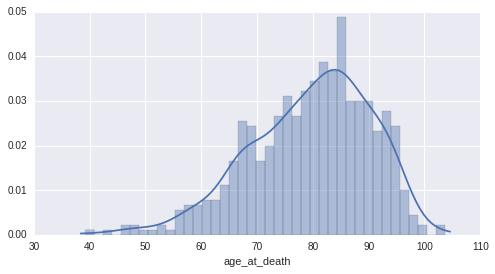

In [93]:
age_at_death = df[df.age_at_death.notnull()].age_at_death
sns.distplot(age_at_death, bins=40)

In [44]:
df[df.age_at_death > 100][['name', 'category', 'year']]

                     name                category  year
101          Ronald Coase               Economics  1991
329  Rita Levi-Montalcini  Physiology or Medicine  1986

In [45]:
df_temp = df[df.age_at_death.notnull()]

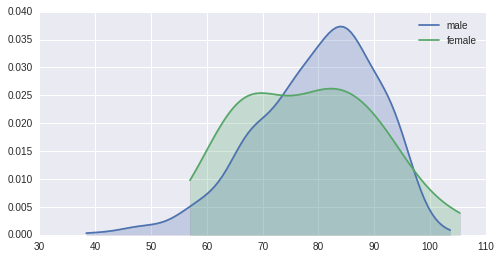

In [46]:
sns.kdeplot(df_temp[(df_temp.gender == 'male')].age_at_death, shade=True, label='male')
sns.kdeplot(df_temp[(df_temp.gender == 'female')].age_at_death, shade=True, label='female')
plt.legend()

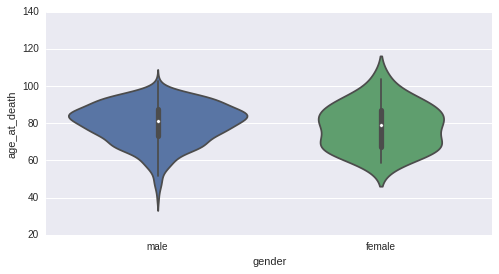

In [98]:
sns.violinplot(df.gender, age_at_death)

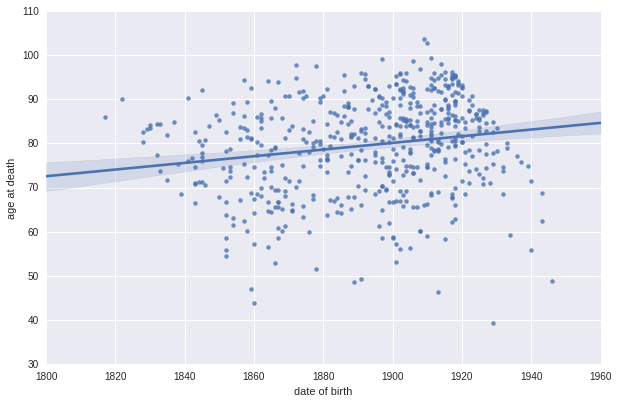

In [48]:
df_temp=df[df.age_at_death.notnull()]
data = pd.DataFrame(
{'age at death':df_temp.age_at_death,
'date of birth':df_temp.date_of_birth.dt.year})
sns.lmplot('date of birth', 'age at death', data, size=6, aspect=1.5)

In [49]:
df = pd.read_json('data/nobel_winners_plus_bornin.json', orient='records')

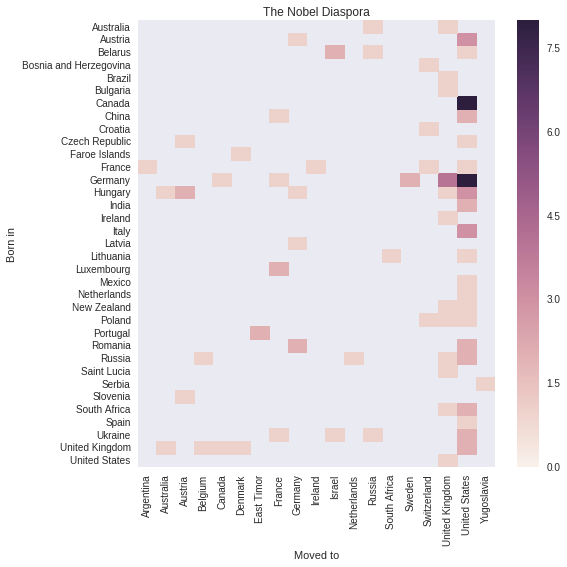

In [50]:
by_bornin_nat = df[df.born_in.notnull()].groupby(\
['born_in', 'country']).size().unstack()
by_bornin_nat.index.name = 'Born in'
by_bornin_nat.columns.name = 'Moved to'
plt.figure(figsize=(8,8))
ax = sns.heatmap(by_bornin_nat, vmin=0, vmax=8)
ax.set_title('The Nobel Diaspora')

In [51]:
df.date_of_birth = pd.to_datetime(df.date_of_birth).dt.date

In [52]:
df[(df.born_in == 'Germany') & (df.country == 'United Kingdom')][['name', 'date_of_birth', 'category']]

                  name date_of_birth                category
119  Ernst Boris Chain    1906-06-19  Physiology or Medicine
484   Hans Adolf Krebs    1900-08-25  Physiology or Medicine
486           Max Born    1882-12-11                 Physics
503       Bernard Katz    1911-03-26  Physiology or Medicine